In [1]:
#!pip install opendatasets
#!pip install torchmetrics
import gc
import pandas as pd
import numpy as np
import sklearn as skl
import seaborn as sns
import lightgbm as lgb
import torch
import scipy
import opendatasets as od
import math
import torchmetrics
import matplotlib.pyplot as plt

import importlib
import joblib
import utils.mlp as mlp
import utils.lgbm as lgbm
import utils.mlp_pipeline as mlp_pipeline
#from google.colab import drive

In [2]:
import pickle
import io

class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else:
            return super().find_class(module, name)


In [3]:
def find_optimal_recall(fpr,tpr,threshold,rate):
    optimal_index=np.argmin(abs(fpr-rate*np.ones(len(fpr))))
    
    return tpr[optimal_index]

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Using {device} device")

Using cpu device


In [5]:

data1=pd.read_csv("./creditcardfraud/creditcard.csv")
X=data1.loc[:,'V1':'Amount']
Y=data1.Class

training_range=range(0,math.floor(len(Y)*0.8)-1)
val_range=range(math.floor(len(Y)*0.8),math.floor(len(Y)*0.9)-1)
test_range=range(math.floor(len(Y)*0.9),len(Y)-1)
xtrain=X.loc[training_range]
ytrain=Y.loc[training_range]
xval=X.loc[val_range]
yval=Y.loc[val_range]
xtest=X.loc[test_range]
ytest=Y.loc[test_range]

In [6]:
cont_cols=xtrain.columns
cat_cols=[]
param_list=lgbm.lgbm_param_sampler(20,7,'cpu')


In [ ]:

param_list=lgbm.lgbm_param_sampler(20,7,'cpu')

i=0
for params in param_list:
    model = lgb.LGBMClassifier(n_jobs=10, **params)  # Instantiate LGBM Model.
        
    # Fit model to training data.
    model.fit(xtrain, ytrain, categorical_feature=cat_cols,eval_set=[(xval,yval)],early_stopping_rounds=5,eval_metric='loss')
    # Obtain predictions in test data.
    predictions = model.predict_proba(xtest)[:, 1]

    joblib.dump(model,'lgbm_1/lgbm{}.pkl'.format(i))
    i=i+1

i=0


In [ ]:
encoder=data.PiecewiseLinearEncoder('decision_tree',dict(n_bins=4,regression='False', tree_kwargs={'min_samples_leaf': 256}),stack=False)
encoder.fit(torch.tensor(xtrain.values),torch.tensor(ytrain.values)) #the device count fraud feature is constant, and so cannot be fed to this encoder
x_train=encoder.transform(torch.tensor(xtrain.values))
x_val=encoder.transform(torch.tensor(xval.values))
i=0
for params in param_list:
    model = lgb.LGBMClassifier(n_jobs=10, **params)  # Instantiate LGBM Model.
        
    # Fit model to training data.
    model.fit(x_train, ytrain, categorical_feature=cat_cols,eval_set=[(x_val,yval)],early_stopping_rounds=5,eval_metric='loss')

    joblib.dump(model,'lgbm_1/lgbm_numenc{}.pkl'.format(i))
    i=i+1

In [ ]:

# Define number of trials in Random search.
n_trials=20
# Random state for sampling seeds.
np.random.seed(42)

# Variable to store the results.
param_list=mlp.mlp_param_sampler(n_trials, len(xtrain.columns),7,device)

normalization_list=['None','Zscore','MinMax','Median']
for normalization in normalization_list:
    i=0
    xtrain_aux=mlp_pipeline.normalization_transform(xtrain,normalization,cont_cols)
    xval_aux=mlp_pipeline.normalization_transform(xval,normalization,cont_cols)

    for params in param_list[2:]:

        # Fit pipeline
        print('iteration: ',i)
        
        model=mlp_pipeline.pipeline(device,xtrain_aux,xval_aux,ytrain,yval,params,'None',cont_cols)

        #Save the model
        joblib.dump(model,'fraud_mlp/mlp_simple{}{}.pkl'.format(normalization,i))

        i=i+1
    del xval_aux
    del xtrain_aux
    gc.collect()


In [8]:
max_auc=-1000
for i in range(0,50):
    link="lgbm_1/lgbm{}.pkl".format(i)
    file = open(link,'rb')
    model=joblib.load(link)
    predict=model.predict_proba(xval)[:,1]
    auc=skl.metrics.roc_auc_score(yval,predict)
    if max_auc<auc:
        max_auc=auc
        best_model=model
        
predict=model.predict_proba(xtest)[:,1]
auc=skl.metrics.roc_auc_score(ytest,predict)
print(auc)
roc=skl.metrics.roc_curve(ytest,predict,drop_intermediate=False)
recall_lgb=find_optimal_recall(roc[0],roc[1],roc[2],0.05)
print(recall_lgb)

0.9690620627527649
0.8181818181818182


In [59]:
x_test=encoder.transform(torch.tensor(xtest.values))

max_auc=-1000
for i in range(0,20):
    link="lgbm_1/lgbm_numenc{}.pkl".format(i)
    file = open(link,'rb')
    model=joblib.load(link)
    predict=model.predict_proba(x_val)[:,1]
    auc=skl.metrics.roc_auc_score(yval,predict)
    if max_auc<auc:
        max_auc=auc
        best_model=model
        
predict=model.predict_proba(x_test)[:,1]
auc=skl.metrics.roc_auc_score(ytest,predict)
print(auc)
roc=skl.metrics.roc_curve(ytest,predict,drop_intermediate=False)
recall_lgb=find_optimal_recall(roc[0],roc[1],roc[2],0.05)
print(recall_lgb)

0.8465593633999706
0.7272727272727273


In [38]:

max_auc_none=-1000
xtest_device=torch.tensor(xval.values).to(device)
for i in range(0,18):
    link="fraud_mlp/mlp_simpleNone{}.pkl".format(i)
    file = open(link,'rb')
    model = CPU_Unpickler(file).load()
    model.eval()
    output = model(mlp_pipeline.normalization_transform(xval,'None',xval.columns).float()).detach().numpy() 
    auc=skl.metrics.roc_auc_score(yval,output)
    if max_auc_none<auc:
        max_auc_none=auc
        best_model_none=model

max_auc_zscore=-1000
for i in range(0,18):
    link="fraud_mlp/mlp_simpleZscore{}.pkl".format(i)
    file = open(link,'rb')
    model.eval()
    model = CPU_Unpickler(file).load()
    predict = model(mlp_pipeline.normalization_transform(xval,'Zscore',xval.columns).float()).detach().numpy() 
    auc=skl.metrics.roc_auc_score(yval,predict)
    if max_auc_zscore<auc:
        max_auc_zscore=auc
        best_model_zscore=model

        
max_auc_med=-1000
for i in range(0,18):
    link="fraud_mlp/mlp_simpleMedian{}.pkl".format(i)
    file = open(link,'rb')
    model = CPU_Unpickler(file).load()
    model.eval()
    predict = model(mlp_pipeline.normalization_transform(xval,'Median',xval.columns).float()).detach().numpy()
    auc=skl.metrics.roc_auc_score(yval,predict)
    if max_auc_med<auc:
        max_auc_med=auc
        best_model_med=model
    #print(auc)
max_auc_minmax=-1000
for i in range(0,18):
    link="fraud_mlp/mlp_simpleMinMax{}.pkl".format(i)
    file = open(link,'rb')
    model = CPU_Unpickler(file).load()
    model.eval()
    predict = model(mlp_pipeline.normalization_transform(xval,'MinMax',xval.columns).float()).detach().numpy()
    auc=skl.metrics.roc_auc_score(yval,predict)
    if max_auc_minmax<auc:
        max_auc_minmax=auc
        best_model_minmax=model

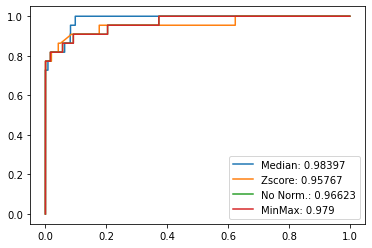

Recall ate FPR=5%
No Norm. 0.81818
Zscore 0.86364
Median 0.81818
MinMax 0.86364


In [42]:
best_model_none.eval()
best_model_zscore.eval()

best_model_med.eval()

roc_none=skl.metrics.roc_curve(ytest,best_model_none(mlp_pipeline.normalization_transform(xtest,'None',xtest.columns).float()).detach().numpy(),drop_intermediate=False)
roc_zscore=skl.metrics.roc_curve(ytest,best_model_zscore(mlp_pipeline.normalization_transform(xtest,'Zscore',xtest.columns).float()).detach().numpy(),drop_intermediate=False)
roc_med=skl.metrics.roc_curve(ytest,best_model_med(mlp_pipeline.normalization_transform(xtest,'Median',xtest.columns).float()).detach().numpy(),drop_intermediate=False)
roc_minmax=skl.metrics.roc_curve(ytest,best_model_minmax(mlp_pipeline.normalization_transform(xtest,'MinMax',xtest.columns).float()).detach().numpy(),drop_intermediate=False)


plt.plot(roc_med[0],roc_med[1],label="Median: {}".format(round(skl.metrics.roc_auc_score(ytest,best_model_med(mlp_pipeline.normalization_transform(xtest,'Median',xtest.columns).float()).detach().numpy()),5)))
plt.plot(roc_zscore[0],roc_zscore[1],label="Zscore: {}".format(round(skl.metrics.roc_auc_score(ytest,best_model_zscore(mlp_pipeline.normalization_transform(xtest,'Zscore',xtest.columns).float()).detach().numpy()),5)))
plt.plot(roc_none[0],roc_none[1],label="No Norm.: {}".format(round(skl.metrics.roc_auc_score(ytest,best_model_none(mlp_pipeline.normalization_transform(xtest,'None',xtest.columns).float()).detach().numpy()),5)))
plt.plot(roc_none[0],roc_none[1],label="MinMax: {}".format(round(skl.metrics.roc_auc_score(ytest,best_model_minmax(mlp_pipeline.normalization_transform(xtest,'MinMax',xtest.columns).float()).detach().numpy()),5)))


plt.legend(loc="lower right")
plt.show()


recall_none=find_optimal_recall(roc_none[0],roc_none[1],roc_none[2],0.05)
recall_zscore=find_optimal_recall(roc_zscore[0],roc_zscore[1],roc_zscore[2],0.05)
recall_med=find_optimal_recall(roc_med[0],roc_med[1],roc_med[2],0.05)
recall_minmax=find_optimal_recall(roc_minmax[0],roc_minmax[1],roc_minmax[2],0.05)

print("Recall ate FPR=5%")
print("No Norm.",round(recall_none,5))
print("Zscore",round(recall_zscore,5))
print("Median",round(recall_med,5))
print("MinMax",round(recall_minmax,5))


# Numerical Encodings

In [7]:
import rtdl.rtdl.data as data
import mlp_pipeline

In [8]:
#For the categorical data, we will be using the Catboost Encoder, which has been shown to work the best for this dataset
mlp_params=mlp.mlp_param_sampler(20, len(xtrain.columns),7,device)

encoder=data.PiecewiseLinearEncoder('decision_tree',dict(n_bins=4,regression='False', tree_kwargs={'min_samples_leaf': 256}),stack=False)
encoder.fit(torch.tensor(xtrain.values),torch.tensor(ytrain.values)) #the device count fraud feature is constant, and so cannot be fed to this encoder
joblib.dump(encoder, "fraud_mlp/numerical_encoder.pkl")
x_train=encoder.transform(torch.tensor(xtrain.values))
x_val=encoder.transform(torch.tensor(xval.values))
i=0
for param in mlp_params:
    
        
    model=mlp_pipeline.pipeline(device,x_train,x_val,ytrain,yval,param,'None',xtrain.columns.difference(['device_fraud_count']))
    joblib.dump(model,"fraud_mlp/mlp1_encoded{}_dim{}.pkl".format(i,4) )
    i=i+1

    gc.collect()


----------Method:  None -------------
Train size:  227844 ; Number of 0:  227427 ; Number of 1: 417
Val size:  28480 ; Number of 0:  28427 ; Number of 1: 53
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 3 out of 5
EarlyStopping counter: 4 out of 5
EarlyStopping counter: 5 out of 5
Early stopping
----------Method:  None -------------
Train size:  227844 ; Number of 0:  227427 ; Number of 1: 417
Val size:  28480 ; Number of 0:  28427 ; Number of 1: 53
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 3 out of 5
EarlyStopping counter: 4 out of 5
EarlyStopping counter: 5 out of 5
Early stopping
----------Method:  None -------------
Train size:  227844 ; Number of 0:  227427 ; Number of 1: 417
Val size:  28480 ; Number of 0:  28427 ; Number of 1: 53
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 

EarlyStopping counter: 4 out of 5
EarlyStopping counter: 5 out of 5
Early stopping
----------Method:  None -------------
Train size:  227844 ; Number of 0:  227427 ; Number of 1: 417
Val size:  28480 ; Number of 0:  28427 ; Number of 1: 53
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 3 out of 5
EarlyStopping counter: 4 out of 5
EarlyStopping counter: 5 out of 5
Early stopping
----------Method:  None -------------
Train size:  227844 ; Number of 0:  227427 ; Number of 1: 417
Val size:  28480 ; Number of 0:  28427 ; Number of 1: 53
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 3 out of 5
EarlyStopping counter: 4 out of 5
EarlyStopping counter: 5 out of 5
Early stopping


In [36]:
joblib.dump(encoder,'fraud_mlp/numerical_encoder.pkl')

['fraud_mlp/numerical_encoder.pkl']

In [9]:
max_auc_none=0
res=np.zeros([7,30])
best_models=[]
max_auc=0

for i in range(0,20):
    x_val=encoder.transform(torch.tensor(xval.values))

    model=joblib.load("fraud_mlp/mlp1_encoded{}_dim4.pkl".format(i))
    model.eval()
    
    output = model(x_val.float()).detach().numpy() 
    auc=skl.metrics.roc_auc_score(yval,output)
    if auc>max_auc:
        best_model=model
        max_auc=auc
            
    
#Results for test set:
j=0


x_test=encoder.transform(torch.tensor(xtest.values))
best_model.eval()
output=best_model(x_test.float()).detach().numpy() 
auc=skl.metrics.roc_auc_score(ytest,output)
roc=skl.metrics.roc_curve(ytest,output,drop_intermediate=False)
recall=find_optimal_recall(roc[0],roc[1],roc[2],0.05)
    
print("Dim ",4,"-----",round(auc,5),"&",round(recall,6))
j=j+1

Dim  4 ----- 0.97812 & 0.909091
